In [6]:
# Basic Libraries for data analysis 
import pandas as pd
import numpy as np
import random as rnd
import math
import gc # garbage collection
from tqdm import tqdm # check eta
tqdm.pandas()

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Deep learning
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding 
from keras.layers import LSTM, Flatten, SpatialDropout1D, Bidirectional, CuDNNLSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.normalization import BatchNormalization

# NLP related LSTM
import re
from gensim.models import Word2Vec  # Word embeddings

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [7]:
# categories: naming 

import json

with open('../categories.json','r') as f:
    allCat = json.load(f)
    
print('The top level categories are: {}'.format(list(allCat.keys())))

print('There are {} categories in Mobile'.format(len(allCat['Mobile'])))
print('There are {} categories in Fashion'.format(len(allCat['Fashion'])))
print('There are {} categories in Beauty'.format(len(allCat['Beauty'])))

mobCat = sorted(list(allCat['Mobile'].values()))
fasCat = sorted(list(allCat['Fashion'].values()))
beuCat = sorted(list(allCat['Beauty'].values()))

folder_path_dict = {i:'Mobile' for i in mobCat}
folder_path_dict.update({i:'Fashion' for i in fasCat})
folder_path_dict.update({i:'Beauty' for i in beuCat})

# dict for category mapping
numerical2label = {}
labels = allCat

for master_label in labels.keys():
    master_dict = labels[master_label]
    for item_name, item_idx in master_dict.items():
        numerical2label[item_idx] = item_name
        
# inverse map     
label2numerical = {}
for item_idx, item_name in numerical2label.items():
    label2numerical[item_name] = item_idx

The top level categories are: ['Mobile', 'Fashion', 'Beauty']
There are 27 categories in Mobile
There are 14 categories in Fashion
There are 17 categories in Beauty


## Load Train and Test Data

In [8]:
# Load in the train and test datasets
df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')

In [9]:
# Set Meta Category to Train and Test DF
train_df = df_train.copy()
test_df = df_test.copy()

train_df['meta_cat'] = train_df.loc[:,'image_path'].apply(lambda x: x.split('/')[0]) 
test_df['meta_cat'] = test_df.loc[:,'image_path'].apply(lambda x: x.split('/')[0]) 

## Mobile

In [10]:
# Let's train only fashion
train_gr = train_df.groupby('meta_cat')
test_gr = test_df.groupby('meta_cat')

mobile = train_gr.get_group('mobile_image')
mobile_test = test_gr.get_group('mobile_image')

print('Beauty train shape = {}'.format(mobile.shape))
print('Beauty test shape = {}'.format(mobile_test.shape))

Beauty train shape = (160330, 5)
Beauty test shape = (40417, 4)


In [6]:
cut_off = 1000 # NOT USEFUL
Zone1 = np.unique(mobile.iloc[:cut_off].Category.values)
Zone2 = np.unique(mobile.iloc[-cut_off:].Category.values)

In [9]:
Zone1

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54])

In [10]:
Zone2

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 51, 52, 53, 54, 56])

In [11]:
# Set weights for imbalanced classes
# compute class fractions
mob_grp = mobile.groupby('Category')
ns = len(mobile)
ngrp = len(mob_grp.groups)
frac_vec = np.zeros((ngrp,1))

for i in range(ngrp):
    cur = mob_grp.get_group(i+31)
    frac = len(cur)/ns
    frac_vec[i,0] = frac

def set_weights(label):
    idx = int(label) - 31 # 31 is start for mobile
    frac = frac_vec[idx]
    wg = 1.0/frac
    weight = min(10,wg)
    weight = float(weight)
    
    return weight

In [12]:
mobile = mobile.copy()
mobile['weight']=mobile['Category'].apply(lambda x: set_weights(x))

In [ ]:
mobile.head(10)

In [13]:
mobile['length'] = mobile['title'].apply(lambda x: len(x.split()))

In [14]:
## Group by 
fas_gr = mobile.groupby('Category')
for i in range(31,58):
    cur_cat = fas_gr.get_group(i)
    lens = np.mean(cur_cat.length.values)
    sd = np.std(cur_cat.length.values)
    print('Categoty = {}'.format(numerical2label[i]))
    print('len = {}, SD = {}'.format(lens,sd))

Categoty = Iphone
len = 8.53560137950855, SD = 4.241013419082775
Categoty = Samsung
len = 8.8081602473617, SD = 4.368160797425592
Categoty = Sony
len = 8.549056212404066, SD = 3.691641899490964
Categoty = Xiaomi
len = 9.624133713819813, SD = 4.240371679970379
Categoty = Others Mobile & Tablet
len = 9.345308924485126, SD = 4.03542462534663
Categoty = Blackberry
len = 6.898832684824903, SD = 3.3498183061276454
Categoty = Lenovo
len = 8.173415492957746, SD = 4.087278135845414
Categoty = Nokia
len = 6.577291090793111, SD = 3.4383997672599445
Categoty = Brandcode
len = 6.246771879483501, SD = 3.0508731108474305
Categoty = Infinix
len = 8.480122324159021, SD = 3.830355496116126
Categoty = Oppo
len = 8.174658243579122, SD = 4.824347714366994
Categoty = Vivo
len = 8.161016949152541, SD = 4.849876559388373
Categoty = Asus
len = 9.307304376118433, SD = 3.870619940044753
Categoty = Evercoss
len = 7.084782608695652, SD = 3.782308208954372
Categoty = Advan
len = 7.17129840546697, SD = 3.66200660725

#### I am using three models at the base level. Later, these models will be combined using xgBoost 

## Model 1 : MobileNet for Image Data

In [12]:
# Load pre computed image embeddings for train and test
with open('X_IMG_MOB_TRAIN.npy', 'rb') as f:
    X_IMG_MOB_TRAIN = np.load(f)
    
with open('X_IMG_MOB_TEST.npy', 'rb') as f:
    X_IMG_MOB_TEST = np.load(f)
    
print('Shape of train image embeddings:{}'.format(X_IMG_MOB_TRAIN.shape))
print('Shape of test image embeddings:{}'.format(X_IMG_MOB_TEST.shape))

Shape of train image embeddings:(160330, 1024)
Shape of test image embeddings:(40417, 1024)


In [ ]:
gc.collect()

### Train - Validation - Test Split

In [13]:
# Make train-test split
train_df, cv_df, train_img, cv_img = train_test_split(mobile, X_IMG_MOB_TRAIN, test_size=0.02, random_state=8, 
                                     shuffle=True, stratify=mobile['Category'])
test_df = mobile_test.copy()

ntrain = train_df.shape[0]
ncv = cv_df.shape[0]
ntest = len(test_df)

print('Number of observations in train set: %d' % ntrain)
print('Number of observations in validation set: %d' % ncv)
print('Number of observations in test set: %d' % ntest)
      
SEED = 8 # for reproducibility
NFOLDS = 4 # set folds for out-of-fold prediction

# K-fond cross validation
num_cat = 58

oof_train = np.zeros((ntrain,num_cat)) # to store the outputs
oof_cv = np.zeros((ncv,num_cat)) 
oof_cv_skf = np.zeros((NFOLDS, ncv, num_cat))

Number of observations in train set: 157123
Number of observations in validation set: 3207
Number of observations in test set: 40417


In [15]:
# Image model: build on mobilenet

def image_model():
    img_input = Input(shape=(1024,), name='img_input')
    x = BatchNormalization()(img_input)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu', name= 'fc-1')(x) # dense 1
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    out = Dense(58, activation = 'softmax', name = 'out_layer')(x)

    # Build the Model
    img_model = Model(inputs=img_input, outputs=out)
    
    # Compile the Model
    img_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    
    return img_model

In [16]:
# Write a generate function to train the image model

def img_gen(X, y, batch_size):
    
    n_batches = math.floor(len(X) / batch_size)
    
    while True: 
        X,y = shuffle(X,y) # Shuffle the index.
        
        for i in range(n_batches):
            
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]
            
            yield X_batch, y_batch

In [17]:
# Setup KFold CrossValidation

ntrain = train_df.shape[0]
ncv = cv_df.shape[0]
ntest = test_df.shape[0]

SEED = 8 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold (OOF) predictions

# K-fold cross validation (temp variables)
num_cat = 58
oof_train = np.zeros((ntrain,num_cat)) # to store the outputs

oof_cv = np.zeros((ncv,num_cat)) 
oof_cv_skf = np.zeros((NFOLDS, ncv, num_cat))

oof_test = np.zeros((ntest,num_cat)) 
oof_test_skf = np.zeros((NFOLDS, ntest, num_cat))

# Get the image encodings for cv and test set
cv_img = cv_img.copy()
test_img = X_IMG_MOB_TEST.copy()

In [ ]:
# Iterate over KFolds

kf = KFold(n_splits= NFOLDS, shuffle = True, random_state=SEED)
kf_splits = kf.split(train_df)

# iterations
for i, (train_index, valid_index) in enumerate(kf_splits):
    
    print('======== CV {} =========='.format(i+1))
    
    X_tr = train_df.iloc[train_index]
    X_val = train_df.iloc[valid_index]
    
    print('Shape of oof valid = {}'.format(X_val.shape))

    train_enc = train_img[train_index,:]
    y_tr = X_tr.Category.values
    tr_target = np.zeros((len(y_tr), num_cat))
    tr_target[np.arange(len(y_tr)), y_tr] = 1

    
    val_enc = train_img[valid_index,:]
    y_val = X_val.Category.values
    val_target = np.zeros((len(y_val), num_cat))
    val_target[np.arange(len(y_val)), y_val] = 1
    
    # Compile model
    model = image_model()
    
    batch_size = 32
    data_gen = img_gen(train_enc, tr_target, batch_size)

    n_steps = len(X_tr) // batch_size

    history = model.fit_generator(data_gen, epochs=15, 
                              steps_per_epoch=n_steps, 
                              validation_data=(val_enc, val_target), 
                              verbose=True)

    # make prediction for the validation set
    y_pred_valid = model.predict(val_enc)
    y_pred_cv = model.predict(cv_img)
    y_pred_test = model.predict(test_img)

    oof_train[valid_index] = y_pred_valid
    oof_cv_skf[i, :] = y_pred_cv
    oof_test_skf[i, :] = y_pred_test
    
    del model
    gc.collect()

In [ ]:
# Maybe run a few more epochs for image model?

# Take mean of test and cv predictions
OOF_train_IMG = oof_train

oof_cv[:] = oof_cv_skf.mean(axis=0)
oof_test[:] = oof_test_skf.mean(axis=0)

OOF_cv_IMG = oof_cv
OOF_test_IMG = oof_test

# Save variables for potential later use
with open('OOF_train_IMG.npy','wb') as f:
    np.save(f,OOF_train_IMG)

with open('OOF_cv_IMG.npy','wb') as f:
    np.save(f,OOF_cv_IMG)
    
with open('OOF_test_IMG.npy','wb') as f:
    np.save(f,OOF_test_IMG)

In [17]:
## cv prediction
cv_pred = np.argmax(OOF_cv_IMG, axis=1)
cv_label = cv_df.Category.values

In [18]:
# Check accuracy of cross validation set
count = 0
for i in range(len(cv_pred)):
    if (cv_pred[i]==cv_label[i]):
        count = count+1
acc = count/len(cv_pred)*100
print('CV accuracy from image = {}'.format(acc))

CV accuracy from image = 55.285313376987844


## Model-2: LSTM + word2vec

In [18]:
# Consider doing some pre-processing for title test
sentences = pd.concat([train_df['title'], cv_df['title'],test_df['title']],axis=0)
train_sentences = list(sentences.progress_apply(str.split).values)

100%|██████████| 200747/200747 [00:00<00:00, 288575.36it/s]


In [19]:
# Build model for custom word embeddings

import time
start_time = time.time()

text_model = Word2Vec(min_count=5, window=3, size=100, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20)
text_model.build_vocab(train_sentences, progress_per=10000)

text_model = Word2Vec(sentences=train_sentences, sg=1, window=3, size=100)

print('The number of word for which embeddings will be computed: %d' %len(text_model.wv.vocab))

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

The number of word for which embeddings will be computed: 8636
Time taken : 0.21 mins


In [20]:
# Train the word2vec model

start_time = time.time()

text_model.train(sentences = train_sentences, total_examples=text_model.corpus_count, epochs=50, report_delay=1)

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 1.92 mins


In [21]:
# Save/load test model
text_model.save("w2v_100d_mobile.model")
# text_model = Word2Vec.load("w2v_300d_mobile.model")

In [22]:
# Compute maximum title length

max_len = 0
idx = 0
for i in range(len(train_sentences)):
    if(len(train_sentences[i])>max_len):
        max_len = len(train_sentences[i])
        idx = i
print('Maximum sentence length = {}'.format(max_len))
# print(train_sentences[idx])

Maximum sentence length = 27


In [23]:
# All titles contain less than 32 words
max_length = 32 # maximum length of title
max_features = 9000 # this is the number of words we care about

train_titles = train_df.title.values
cv_titles = cv_df.title.values
test_titles = test_df.title.values 

frms = [train_titles, cv_titles, test_titles]
all_titles = np.concatenate(frms, axis=0)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(all_titles)

cv_seq = tokenizer.texts_to_sequences(cv_titles)
cv_seq_padded = pad_sequences(cv_seq, maxlen=max_length)

test_seq = tokenizer.texts_to_sequences(test_titles)
test_seq_padded = pad_sequences(test_seq, maxlen=max_length)

In [24]:
num_cat = 58
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

vocab_size = len(tokenizer.word_index) + 1

Found 26999 unique tokens.


In [25]:
# Preparing the Embedding layer
num_words = min(max_features, vocab_size) + 1
#print(num_words)

embedding_dim = 100
count = 0

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    #model.wv.get_vector('iphone')
    if word in text_model.wv.vocab.keys():
        embedding_vector = text_model.wv.get_vector(word)
        count = count + 1
    else:
        embedding_vector = None
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
        
print('Total number of words considered = %s.'% num_words)
print('No of embeddings found in text model = %s.'% count)
print('The shape of embedding matrix: {}'.format(embedding_matrix.shape))

Total number of words considered = 9001.
No of embeddings found in text model = 8170.
The shape of embedding matrix: (9001, 100)


In [30]:
# Define the LSTM model
# Perform grid search for tuning hyperparameters

def LSTM_model():
    
    LSTM_model = Sequential()
    LSTM_model.add(Embedding(num_words,
                        embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=max_length,
                        trainable=False))
    LSTM_model.add(SpatialDropout1D(0.3))
    LSTM_model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
    LSTM_model.add(Bidirectional(CuDNNLSTM(128)))
    LSTM_model.add(Dropout(0.5))
    LSTM_model.add(Dense(units=58, activation='softmax'))
    LSTM_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    return LSTM_model

In [31]:
# Generator for training LSTM model

def batch_gen(train_df, batch_size):
    n_batches = math.floor(len(train_df) / batch_size)
    
    while True: 
        train_df = train_df.sample(frac=1.)  # Shuffle the data.
        
        for i in range(n_batches):
            
            batch_df = train_df.iloc[i*batch_size:(i+1)*batch_size]
            batch_titles = batch_df['title']
            batch_seq = tokenizer.texts_to_sequences(batch_titles)
            batch_seq_padded = pad_sequences(batch_seq, maxlen=max_length)
                        
            batch_labels = batch_df.Category.values
            batch_targets = np.zeros((batch_size, num_cat))
            batch_targets[np.arange(batch_size), batch_labels] = 1
            
            yield batch_seq_padded, batch_targets

In [32]:
# Kfold iterations
ntrain = train_df.shape[0]
ncv = cv_df.shape[0]
ntest = test_df.shape[0]

SEED = 8 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

# K-fond cross validation
oof_train = np.zeros((ntrain,num_cat)) # to store the outputs

oof_cv = np.zeros((ncv,num_cat)) 
oof_cv_skf = np.zeros((NFOLDS, ncv, num_cat))

oof_test = np.zeros((ntest,num_cat)) 
oof_test_skf = np.zeros((NFOLDS, ntest, num_cat))

In [33]:
# Iterate over k-folds
# KF generator

kf = KFold(n_splits= NFOLDS, shuffle = True, random_state=8)
kf_splits = kf.split(train_df)

for i, (train_index, valid_index) in enumerate(kf_splits):
    
    print('======== CV {} =========='.format(i+1))
    X_tr = train_df.iloc[train_index]
    X_val = train_df.iloc[valid_index]
    
    print('Shape of valid = {}'.format(X_val.shape))
    #print(X_val.head(3).title)
    
    val_titles = X_val.title.values
    val_seq = tokenizer.texts_to_sequences(val_titles)
    val_seq_padded = pad_sequences(val_seq, maxlen=max_length)
    
    y_val = X_val.Category.values
    val_target = np.zeros((len(y_val), num_cat))
    val_target[np.arange(len(y_val)), y_val] = 1
    
    # Compile model
    model = LSTM_model()
    
    batch_size = 64
    data_gen = batch_gen(X_tr,batch_size)
    
    n_steps = int(0.5*(len(train_df)//batch_size))

    history = model.fit_generator(data_gen, epochs=7, 
                              steps_per_epoch=n_steps, 
                              validation_data=(val_seq_padded, val_target), 
                              verbose=True)

    # make prediction for the validation set
    y_pred_valid = model.predict(val_seq_padded)
    y_pred_cv = model.predict(cv_seq_padded)
    y_pred_test = model.predict(test_seq_padded)

    oof_train[valid_index] = y_pred_valid
    oof_cv_skf[i, :] = y_pred_cv
    oof_test_skf[i, :] = y_pred_test
    
    del model
    gc.collect()

======== CV 1 ==========
Shape of valid = (31425, 5)
Epoch 1/7
1227/1227 [==============================] - 21s 17ms/step - loss: 0.9704 - acc: 0.7352 - val_loss: 0.7492 - val_acc: 0.7828
Epoch 2/7
1227/1227 [==============================] - 19s 16ms/step - loss: 0.7948 - acc: 0.7720 - val_loss: 0.7192 - val_acc: 0.7857
Epoch 3/7
1227/1227 [==============================] - 20s 16ms/step - loss: 0.7501 - acc: 0.7819 - val_loss: 0.6903 - val_acc: 0.7916
Epoch 4/7
1227/1227 [==============================] - 20s 16ms/step - loss: 0.7250 - acc: 0.7873 - val_loss: 0.6766 - val_acc: 0.7966
Epoch 5/7
1227/1227 [==============================] - 20s 16ms/step - loss: 0.7096 - acc: 0.7898 - val_loss: 0.6628 - val_acc: 0.7996
Epoch 6/7
 597/1227 [=============>................] - ETA: 8s - loss: 0.6903 - acc: 0.7947

KeyboardInterrupt: 

In [ ]:
OOF_train_LSTM = oof_train

oof_cv[:] = oof_cv_skf.mean(axis=0)
OOF_cv_LSTM = oof_cv

oof_test[:] = oof_test_skf.mean(axis=0)
OOF_test_LSTM = oof_test

with open('OOF_train_LSTM.npy','wb') as f:
    np.save(f,OOF_train_LSTM)

with open('OOF_cv_LSTM.npy','wb') as f:
    np.save(f,OOF_cv_LSTM)
    
with open('OOF_test_LSTM.npy','wb') as f:
    np.save(f,OOF_test_LSTM)

In [19]:
## cv prediction
cv_pred = np.argmax(OOF_cv_LSTM, axis=1)
cv_label = cv_df.Category.values

## Accuracy
count = 0
for i in range(len(cv_pred)):
    if (cv_pred[i]==cv_label[i]):
        count = count+1
acc = count/len(cv_pred)*100
print('CV accuracy from text LSTM = {}'.format(acc))

CV accuracy from text LSTM = 83.72310570626755


## Model 3:  TF-iDF + SVD

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(train_df.title.values)

xtrain_tfv =  tfv.transform(train_df.title.values) 
xcv_tfv =  tfv.transform(cv_df.title.values) 
xtest_tfv =  tfv.transform(test_df.title.values) 

In [ ]:
# Take Singular Value Decomposition: SVD

from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, decomposition

# Apply SVD, I chose 300 components

svd = decomposition.TruncatedSVD(n_components=300)
svd.fit(xtrain_tfv)

xtrain_svd = svd.transform(xtrain_tfv)
xcv_svd = svd.transform(xcv_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD

scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)

xtrain_svd_scl = scl.transform(xtrain_svd)
xcv_svd_scl = scl.transform(xcv_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [ ]:
## TF-iDF Model
# Build the model
def TF_model():
    
    TF_model = Sequential()
    TF_model.add(Dense(units = 512, input_shape=(300,),activation="relu"))
    TF_model.add(Dropout(0.5))
    TF_model.add(Dense(units = 58,activation="softmax"))


    TF_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return TF_model

In [ ]:
# Generator for TF-iDF model

def TF_batch_gen(X_tr,data_tr,batch_size):
    n_batches = math.floor(len(data_tr) // batch_size)
    
    while True: 
        X_tr, data_tr = shuffle(X_tr,data_tr)  # Shuffle the data.
        for i in range(n_batches):
            X_train = X_tr[i*batch_size:(i+1)*batch_size,:]
            y_train = data_tr.iloc[i*batch_size:(i+1)*batch_size].Category.values
            
            batch_targets = np.zeros((batch_size, 58))
            batch_targets[np.arange(batch_size), y_train] = 1
            
            yield X_train, batch_targets

In [ ]:
# Prepare kfold variables

ntrain = train_df.shape[0]
ncv = cv_df.shape[0]
ntest = test_df.shape[0]
SEED = 8 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

# K-fond cross validation
num_cat = 58
oof_train = np.zeros((ntrain,num_cat)) # to store the outputs

oof_cv = np.zeros((ncv,num_cat)) 
oof_cv_skf = np.zeros((NFOLDS, ncv, num_cat))

oof_test = np.zeros((ntest,num_cat)) 
oof_test_skf = np.zeros((NFOLDS, ntest, num_cat))

In [ ]:
# KF generator and iterate

kf = KFold(n_splits= NFOLDS, shuffle = True, random_state=8)
kf_splits = kf.split(train_df)

for i, (train_index, valid_index) in enumerate(kf_splits):
    
    print('======== CV {} =========='.format(i+1))
    
    X_tr = xtrain_svd_scl[train_index]
    X_val = xtrain_svd_scl[valid_index]
    
    data_tr = train_df.iloc[train_index]
    data_val = train_df.iloc[valid_index]
    
    print('Shape of valid = {}'.format(X_val.shape))
    
    y_val = data_val.Category.values
    val_target = np.zeros((len(y_val), num_cat))
    val_target[np.arange(len(y_val)), y_val] = 1
    
    # Compile model
    model = TF_model()
    batch_size = 32
    
    data_gen = TF_batch_gen(X_tr,data_tr,batch_size)

    steps_per_epoch = int(0.75*(len(train_df)//batch_size))

    history = model.fit_generator(data_gen, epochs=4, 
                              steps_per_epoch=steps_per_epoch, 
                              validation_data=(X_val, val_target), 
                              verbose=True)

    # make prediction for the validation set
    
    y_pred_valid = model.predict(X_val)
    y_pred_cv = model.predict(xcv_svd_scl)
    y_pred_test = model.predict(xtest_svd_scl)

    oof_train[valid_index] = y_pred_valid
    oof_cv_skf[i, :] = y_pred_cv
    oof_test_skf[i, :] = y_pred_test
    
    del model
    gc.collect()

In [ ]:
# Save variables for future use

OOF_train_TF = oof_train

oof_cv[:] = oof_cv_skf.mean(axis=0)
oof_test[:] = oof_test_skf.mean(axis=0)

OOF_cv_TF = oof_cv
OOF_test_TF = oof_test

with open('OOF_train_TF.npy','wb') as f:
    np.save(f,OOF_train_TF)

with open('OOF_cv_TF.npy','wb') as f:
    np.save(f,OOF_cv_TF)
    
with open('OOF_test_TF.npy','wb') as f:
    np.save(f,OOF_test_TF)

In [20]:
##
## cv prediction
cv_pred = np.argmax(OOF_cv_TF, axis=1)
cv_label = cv_df.Category.values

## Accuracy
count = 0
for i in range(len(cv_pred)):
    if (cv_pred[i]==cv_label[i]):
        count = count+1
acc = count/len(cv_pred)*100
print('CV accuracy from text TFiDF = {}'.format(acc))

CV accuracy from text TFiDF = 80.0124727159339


## Stacking - Meta Learner: xgBoost

In [ ]:
## Magic feature??

In [14]:
# Load train files
with open('OOF_train_LSTM.npy','rb') as f:
    OOF_train_LSTM = np.load(f)
    
with open('OOF_train_TF.npy','rb') as f:
    OOF_train_TF = np.load(f)

with open('OOF_train_IMG.npy','rb') as f:
    OOF_train_IMG = np.load(f)

# Load cv files
with open('OOF_cv_LSTM.npy','rb') as f:
    OOF_cv_LSTM = np.load(f)
    
with open('OOF_cv_TF.npy','rb') as f:
    OOF_cv_TF = np.load(f)

with open('OOF_cv_IMG.npy','rb') as f:
    OOF_cv_IMG = np.load(f)

# Load test files
with open('OOF_test_LSTM.npy','rb') as f:
    OOF_test_LSTM = np.load(f)
    
with open('OOF_test_TF.npy','rb') as f:
    OOF_test_TF = np.load(f)

with open('OOF_test_IMG.npy','rb') as f:
    OOF_test_IMG = np.load(f)

# Load test files


In [15]:
x_train = np.concatenate(( OOF_train_LSTM[:,31:], OOF_train_TF[:,31:],OOF_train_IMG[:,31:]), axis=1)
x_cv = np.concatenate(( OOF_cv_LSTM[:,31:], OOF_cv_TF[:,31:],OOF_cv_IMG[:,31:]), axis=1)
x_test = np.concatenate(( OOF_test_LSTM[:,31:], OOF_test_TF[:,31:],OOF_test_IMG[:,31:]), axis=1)

y_train = train_df.Category.values


In [12]:
train_df.head()

,itemid,title,Category,image_path,meta_cat,weight
642366,1422789361,polytron l501 4g,35,mobile_image/10d4d94d2a7a36d270dfae94cb42315f.jpg,mobile_image,5.241255
540562,729513171,iphone x 10 256gb space grey dan silver,31,mobile_image/f9fbe5792949e515f4181a1cca40c31b.jpg,mobile_image,5.759807
643073,965099747,promo khusus hari ini wa 083136481188 beli 2 g...,41,mobile_image/0eb8ad8b4b9a6b23080b273d8fae6d3a.jpg,mobile_image,8.302092
629603,1717459262,smartphone letv le max 2 x820 5.7 2k 21mp 4gb ...,35,mobile_image/35aeb56dc8af70de33f52aa9c1797713.jpg,mobile_image,5.241255
514448,351467095,oppo f1s,41,mobile_image/aae3a47163b28d14c34ad578d208b916.jpg,mobile_image,8.302092


In [ ]:
x_train.shape

In [27]:
import xgboost as xgb

X_tr, X_val, Y_tr, Y_val, tr_samp, val_samp = train_test_split(x_train, y_train, samp_weight, 
                                            stratify=y_train, random_state=42, test_size=0.2, shuffle=True)

In [ ]:
## Idea: Use pykliep for sample weights for based on train and test distribution

In [28]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 150,
 max_depth= 5,
 min_child_weight= 1,
 #gamma=1,
 gamma=0.1,                        
 subsample=0.7,
 colsample_bytree=1.0,
 objective= 'multi:softmax',
 nthread= 16,
 verbosity=2,
 scale_pos_weight=1).fit(x_train, y_train, eval_set = [(X_tr,Y_tr),(X_val,Y_val)],verbose=2,
                         early_stopping_rounds=10)

[0]	validation_0-merror:0.170687	validation_1-merror:0.167351
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[2]	validation_0-merror:0.167926	validation_1-merror:0.16385
[4]	validation_0-merror:0.166995	validation_1-merror:0.163405
[6]	validation_0-merror:0.166144	validation_1-merror:0.162259
[8]	validation_0-merror:0.165587	validation_1-merror:0.161846
[10]	validation_0-merror:0.165126	validation_1-merror:0.161337
[12]	validation_0-merror:0.164601	validation_1-merror:0.1607
[14]	validation_0-merror:0.164251	validation_1-merror:0.160732
[16]	validation_0-merror:0.163758	validation_1-merror:0.160064
[18]	validation_0-merror:0.16332	validation_1-merror:0.159809
[20]	validation_0-merror:0.163105	validation_1-merror:0.159332
[22]	validation_0-merror:0.162795	validation_1-merror:0.159045
[24]	validation_0-merror:0.162389	validation_1-merror:0.158854
[26]	validation_0-merror:0.

In [29]:
# save xgb
import pickle
pickle.dump(gbm, open("xgb_mobile_step_150.dat", "wb"))

In [30]:
# Make predictions for cv and test set
predictions_cv = gbm.predict(x_cv)
predictions_test = gbm.predict(x_test)

In [31]:
# Compute expected accuracy

Y_val = cv_df.Category.values

count=0
for i in range(len(predictions_cv)):
    if(predictions_cv[i] == Y_val[i]):
        count+=1
acc = count/len(predictions_cv)*100
print('Expected Accuracy after xgBoost = {}'.format(acc))

Expected Accuracy after xgBoost = 83.6919239164328


In [32]:
# Store test predictions
test_df['Category'] = predictions_test
test_df['CatName'] = test_df['Category'].apply(lambda x: numerical2label[x]) 

In [34]:
MOB_df_submit = test_df[['itemid', 'Category']].copy()
MOB_df_submit.to_csv('Mob_submission_v1.csv', index=False)

In [37]:
MOB_df_submit.head(20)

,itemid,Category
131985,1520485457,31
131986,1520516704,34
131987,1520726573,41
131988,1523303826,34
131989,1524467616,45
131990,1524876429,32
131991,1525744340,41
131992,1529179598,42
131993,1529634640,31
131994,1529634708,35


In [ ]:
### --- end of modelling for fashion part --- ###

## Submission

In [9]:
df_beu = pd.read_csv('Beauty_submission_final.csv') # Magic feature
df_fas = pd.read_csv('Fashion_submission_mf_v2_200_tree.csv') # Magic feature
df_mob = pd.read_csv('Mob_submission.csv') # v1 is worse than vo

In [10]:
frms =[df_beu, df_fas,df_mob ]
submission = pd.concat(frms, axis = 0)

In [11]:
submission.head(15)

,itemid,Category
0,370855998,5
1,637234604,5
2,690282890,5
3,930913462,5
4,1039280071,5
5,1327710392,3
6,1328802799,4
7,1330468145,5
8,1677309730,5
9,1683142205,5


In [12]:
submission.to_csv('submission.csv', index=False)

## Debugging

In [17]:
### Debugging
## Debugging
import pickle
xgb = pickle.load(open("xgb_mobile_step_150.dat", "rb"))
predictions_cv = xgb.predict(x_cv)
pred_proba = xgb.predict_proba(x_cv)
truth = cv_df.Category.values

df = cv_df.copy()
df['pred'] = predictions_cv

In [20]:
from sklearn.metrics import confusion_matrix
labels = []
for i in range(58):
    label = numerical2label[i]
    labels.append(label)
    
CF_TXT = confusion_matrix(truth, predictions_cv, labels=np.arange(58))

CF_TXT = pd.DataFrame(CF_TXT, columns = labels, index = labels)
CF_TXT.iloc[31:,31:40]

,Iphone,Samsung,Sony,Xiaomi,Others Mobile & Tablet,Blackberry,Lenovo,Nokia,Brandcode
Iphone,496,16,1,11,19,1,0,1,0
Samsung,9,551,3,2,13,1,0,0,0
Sony,0,0,94,0,1,0,0,0,0
Xiaomi,6,11,0,255,10,0,0,4,0
Others Mobile & Tablet,64,67,9,38,319,3,6,10,0
Blackberry,0,0,0,0,1,20,0,0,0
Lenovo,0,1,0,0,3,0,42,0,0
Nokia,1,2,0,1,0,0,0,90,0
Brandcode,0,0,0,0,4,0,0,0,10
Infinix,0,0,0,0,2,0,0,0,0


In [ ]:
s = pd.read_csv('Mob_submission.csv')

In [ ]:
X = s.groupby('Category')

In [ ]:
len(X.get_group(57))

In [ ]:
### ---- pykliep ------ #### (from GitHub)

In [18]:
x_tr_red = x_train[:50000,0:27]
x_test_red = x_test[:20000,0:27]

(400,)

In [48]:
from numpy import random
from scipy.stats import norm
from densratio import densratio

random.seed(1)
x = x_tr_red
y = x_test_red
result = densratio(x, y)
print(result)

################## Start uLSIF ##################
Searching optimal sigma and lambda...
  sigma = 0.001, lambda = 0.001, score = -0.001
  sigma = 0.003, lambda = 0.001, score = -0.001
  sigma = 0.010, lambda = 0.001, score = -0.003
  sigma = 0.032, lambda = 0.001, score = -0.079
  sigma = 0.100, lambda = 0.001, score = -0.284
  sigma = 0.316, lambda = 0.001, score = -0.403
  sigma = 0.316, lambda = 0.003, score = -0.449
  sigma = 1.000, lambda = 0.032, score = -0.496
  sigma = 1.000, lambda = 0.100, score = -0.497
  sigma = 3.162, lambda = 0.032, score = -0.500
  sigma = 10.000, lambda = 0.003, score = -0.500
Found optimal sigma = 10.000, lambda = 0.003.
Optimizing alpha...
End.
################## Finished uLSIF ###############
Method: uLSIF

Kernel Information:
  Kernel type: Gaussian RBF
  Number of kernels: 100
  Bandwidth(sigma): 10.0
  Centers: matrix([[1.18473314e-01, 6.60717860e-02, 1.33261867e-02, ...,..

Kernel Weights(alpha):
  array([0.00673545, 0.01802365, 0.0098994 , 0.010

In [54]:
resW = result.compute_density_ratio(x)

In [59]:
min(resW)

0.9999311569022794

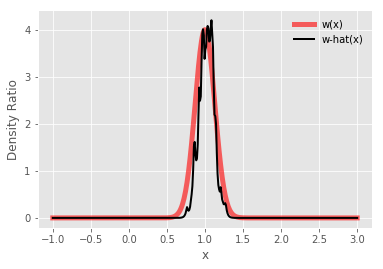

In [46]:
from matplotlib import pyplot as plt
from numpy import linspace

def true_density_ratio(x):
    return norm.pdf(x, 1, 1./8) / norm.pdf(x, 1, 1./2)

def estimated_density_ratio(x):
    return result.compute_density_ratio(x)

x = linspace(-1, 3, 400)
plt.plot(x, true_density_ratio(x), "r-", lw=5, alpha=0.6, label="w(x)")
plt.plot(x, estimated_density_ratio(x), "k-", lw=2, label="w-hat(x)")
plt.legend(loc="best", frameon=False)
plt.xlabel("x")
plt.ylabel("Density Ratio")
plt.show()

In [43]:
##
df = test_df.copy()
df['Category'] = df_mob['Category'].values
df['name']= df['Category'].apply(lambda x: numerical2label[x])

In [41]:
df.head(30)

,itemid,title,image_path,meta_cat,Category
131985,1520485457,new promo iphone 5s 16gb gold ex resmi ibox,mobile_image/876d4a1fe29e056855fa6f9643757b1c.jpg,mobile_image,31
131986,1520516704,new promo xiaomi note 5a prime 3 32gb tam,mobile_image/e2b902b7cd35cd50f061d8e2a3ba7178.jpg,mobile_image,34
131987,1520726573,big produk super murah oppo f5 4gb 32gb fullset,mobile_image/785c03cb1a21a1efedb8c1bbbdb81035.jpg,mobile_image,41
131988,1523303826,pocophone xiaomi f1 ram 6gb rom 128gb,mobile_image/08bb7a43ae0fafd568ad54db908bac0b.jpg,mobile_image,34
131989,1524467616,advan g2,mobile_image/970134be2e5961bda177e9761e1cf6ab.jpg,mobile_image,45
131990,1524876429,samsung galaxy a6,mobile_image/ce06b7eb04ff32e0ba9bd8de93b47955.jpg,mobile_image,32
131991,1525744340,promo akhir bulan oppo f7 diamond black limite...,mobile_image/9c4ed6c4eb9fe1bbfdb873f527896506.jpg,mobile_image,41
131992,1529179598,vivo v9 pro ram 6gb rom 64gb 6,mobile_image/8af91359e6b7f04d8099748d8fbdd200.jpg,mobile_image,42
131993,1529634640,unik telephone panasonic wireless kx tg1611 bl...,mobile_image/f50c21529d6d99a7aa9bafdb56fbe3a8.jpg,mobile_image,31
131994,1529634708,promo telepon wireless panasonic kx tg1611 all...,mobile_image/a3f4f39dad3ec46faf58d9f0e8d4d0f5.jpg,mobile_image,35


In [33]:
df.head(30)

,itemid,title,image_path,meta_cat,name
131985,1520485457,new promo iphone 5s 16gb gold ex resmi ibox,mobile_image/876d4a1fe29e056855fa6f9643757b1c.jpg,mobile_image,NaN
131986,1520516704,new promo xiaomi note 5a prime 3 32gb tam,mobile_image/e2b902b7cd35cd50f061d8e2a3ba7178.jpg,mobile_image,NaN
131987,1520726573,big produk super murah oppo f5 4gb 32gb fullset,mobile_image/785c03cb1a21a1efedb8c1bbbdb81035.jpg,mobile_image,NaN
131988,1523303826,pocophone xiaomi f1 ram 6gb rom 128gb,mobile_image/08bb7a43ae0fafd568ad54db908bac0b.jpg,mobile_image,NaN
131989,1524467616,advan g2,mobile_image/970134be2e5961bda177e9761e1cf6ab.jpg,mobile_image,NaN
131990,1524876429,samsung galaxy a6,mobile_image/ce06b7eb04ff32e0ba9bd8de93b47955.jpg,mobile_image,NaN
131991,1525744340,promo akhir bulan oppo f7 diamond black limite...,mobile_image/9c4ed6c4eb9fe1bbfdb873f527896506.jpg,mobile_image,NaN
131992,1529179598,vivo v9 pro ram 6gb rom 64gb 6,mobile_image/8af91359e6b7f04d8099748d8fbdd200.jpg,mobile_image,NaN
131993,1529634640,unik telephone panasonic wireless kx tg1611 bl...,mobile_image/f50c21529d6d99a7aa9bafdb56fbe3a8.jpg,mobile_image,NaN
131994,1529634708,promo telepon wireless panasonic kx tg1611 all...,mobile_image/a3f4f39dad3ec46faf58d9f0e8d4d0f5.jpg,mobile_image,NaN


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train, sample_weight=weights) # Train using the sample weights!